# NSU, vaje 3

### A: Meta klasifikacija in meta regresija.
A.1: Uporabi meta podatke iz prejsnjih dveh nalog. Razbij jih na testno in ucno mnozico. 
pyMFE nekaterih meta značilk ni mogel izračunati, zato podatki vsebujejo nekaj manjkajočih vrednosti. Odstrani stolpce z njimi.

In [1]:
import numpy as np
import pandas as pd

x_meta_all = pd.read_csv("meta_features.csv")
x_meta = x_meta_all.dropna(axis="columns").drop("name", axis=1)
print(x_meta)

y_meta_all = pd.read_csv("meta_target.csv")
y_meta = y_meta_all["best"]
print(y_meta)

    attr_conc.mean  attr_conc.sd  attr_ent.mean   attr_ent.sd  attr_to_inst  \
0         0.209222      0.119950       2.279010  5.742642e-02      0.026667   
1         0.186128      0.226804       0.761123  3.740142e-01      0.158416   
2         0.076058      0.051457       2.317271  8.810632e-03      0.073034   
3         0.036065      0.030615       1.737425  1.297673e-01      0.025000   
4         0.028040      0.012783       2.000000  0.000000e+00      0.500000   
5         0.009696      0.008027       1.517821  1.833330e-01      0.050000   
6         0.089493      0.106381       2.000000  0.000000e+00      0.050000   
7         0.129066      0.088687       1.998113  2.195144e-03      0.027027   
8         0.104842      0.183616       2.306292  8.090571e-02      0.164948   
9         0.024960      0.009571       2.000000  0.000000e+00      0.050000   
10        0.162223      0.097791       2.243625  1.398410e-01      0.094340   
11        0.041233      0.049976       2.000000  0.0

A.2: Natreniraj meta model z metodo naključnega gozda, ki bo napovedal, katera izmed metod drevo, KNN in Bayes dela najbolje na sestavljenih meta podatkih. 
Za testiranje uporabi 5-kratno prečno preverjanje. Natančnost meta modela primerjaj z natančnostjo modela, ki vedno napove povprečno vrednost ciljne spremenjivke na učni množici (pomagaš si lahko z **sklearn.dummy.DummyClassifier**).

Kakšna se ti zdi uspešnost meta modela?

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

gozd = RandomForestClassifier(200)
dummy_clf = DummyClassifier()
modeli = [gozd, dummy_clf]
rezultati = []
k=5
for model in modeli:
    scores = cross_validate(model, x_meta, y_meta, cv=k,
                         scoring='accuracy')
    avg_scores = sum(scores["test_score"])/k
    rezultati.append(avg_scores)
print(rezultati)

#prvi rezultat za RF drugi za DummyClass

[0.6163636363636363, 0.4618181818181818]


A.3: Naše meta podatke sestavlja kar nekaj različnih meta značilk. Katere so pa zares pomembne in koristne? 
Nekatere metode strojnega učenja nam omogočajo oceno pomembnosti značilk, ki nam lahko pomaga odgovoriti na to vprašanje. Primeri takšnih metod so logistična regresija (izračunamo iz koeficientov **model.coef_**), odločitveno drevo (**model.feature_importances_**) in naključni gozd (**model.feature_importances_**).

Katerih 5 meta značilk je najpomembnejših? Izriši še stolpični diagram (**plt.bar**) pomembnosti meta značilk.

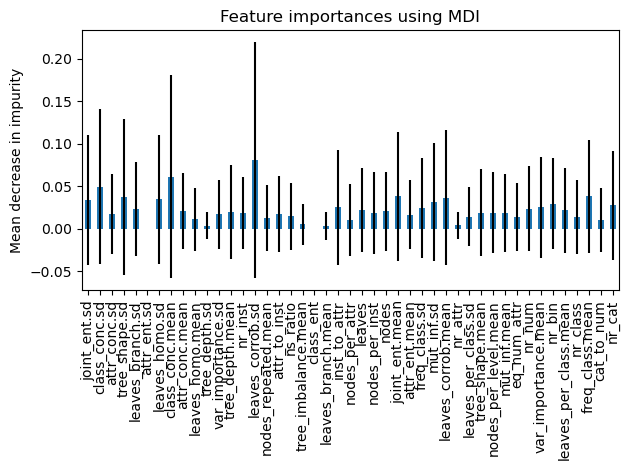

In [3]:
import matplotlib.pyplot as plt

meta_model = RandomForestClassifier(200)
meta_model.fit(x_meta, y_meta)
importance = meta_model.feature_importances_
ind = np.argsort(-importance, axis=0)

feature_names = x_meta.columns[ind]
forest_importances = pd.Series(importance, index=feature_names)
std = np.std([tree.feature_importances_ for tree in meta_model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

A.4: Preizkusimo še meta regresijo. Za vsako od naših treh metod strojnega učenja nauči meta model, ki napoveduje njegovo natančnost. Kolikšen je $R^2$ vsakega meta modela, izračunana s 5-kratnim prečnim preverjanjem?

In [13]:
y_meta_bayes = y_meta_all["bayes"]
y_meta_knn = y_meta_all["knn"]
y_meta_tree = y_meta_all["tree"]

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

gozd = RandomForestRegressor(200)
dummy_clf = DummyClassifier()
modeli = [gozd, dummy_clf]
k=5

y_meta = [y_meta_bayes, y_meta_knn, y_meta_tree]

for model in modeli:
    rezultati = []      
    for y in y_meta:
        scores = cross_validate(model, x_meta, y, cv=k,
                         scoring='neg_mean_sqared_error')
        avg_scores = np.sqrt(-scores["test_score"]).mean()
        rezultati.append(avg_scores)
    print(rezultati)

# zgornji rezultati so za gozd, spodnji za DummyClassifier!

[0.15345465750055987, 0.11003300228026047, 0.11861774015225483]
[0.36142918616492725, 0.30941875963105764, 0.24074736369806032]


A.DODATNO: S posamičnimi regresijskimi meta modeli za natančost iz A.3 lahko napovedujemo tudi najboljši model, tako da pogledamo, katerera od napovedanih natančnosti je najvišja. Primerjaj napovedi najboljšega modela z meta klasifikacijo in z meta regresijo. Katera se obnese bolje?

### B: Optimizacija hiperparametrov
Vse razen najpreprostejših metod strojnega učenja imajo eno ali več nastavitev, ki jim pravimo hiperparametri. Primerna nastavitev hiperparametrov za dane podatke je pogosto prav tako pomembna kot izbira primerne metode. V knjižnici scikit-learn lahko seznam hiperparametrov vsake metode najdemo s klicem **model.get_params()**, da jih zares razumemo, pa je treba pogledati v dokumentacijo ali pa celo prebrati članek o metodi. 

B.1 Naredi model odločitvenega drevesa ter se poigraj z njegovimi hiperparametri. Verjetno bosta najpomembnejša **max_depth** in **min_samples_split**. Za računje uspešnosti modela uporabi metriko $R^2$ in prečno preverjanje.

In [30]:
import numpy as np
import pandas as pd

data = pd.read_csv("drugi_del_podatki.csv")
x = data.drop("y", axis=1)
y = data["y"]

In [34]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor

drevo = DecisionTreeRegressor()
drevo.get_params()

globina = [10,20,30,40,50]
delitev = [2,5,10,15,20]
k = 5

for i in globina:
    rezultati = []
    for j in delitev:
        model = DecisionTreeRegressor(max_depth=i, min_samples_split=j)
        scores = cross_validate(model, x, y, cv=k,
                    scoring='r2')
        avg_scores = sum(scores["test_score"])/k
        rezultati.append(avg_scores)
    print(rezultati)

[0.22109153142237722, 0.24566160556338995, 0.25857518754634606, 0.28094864463673536, 0.2939970080170736]
[0.20862188085440742, 0.22621022319952963, 0.2503241865959002, 0.28132495899053006, 0.2982939596373887]
[0.20529295575989132, 0.22561739664162533, 0.25193968663766597, 0.2804135954053174, 0.2982939596373888]
[0.2123753563988285, 0.21666863487534488, 0.24959494024847437, 0.2804135954053174, 0.2982939596373887]
[0.21516794997009564, 0.2199532693772178, 0.2541434822750507, 0.2804135954053174, 0.2982939596373887]


B.2 Iskanje najboljših hiperparametrov lahko razumemo kot optimizacijski problem. Sci-kit learn nam ponuja nekaj orodij za avtomatsko optimizacijo. Najpreprostejša je **sklearn.model_selection.GridSearchCV**, ki preišče celoten kartezični produkt vrednosti hiperparametrov, ki nas zanimajo.
Uporabi grid search, da preiščeš kombinacije hiperparametrov **2 <= max_depth < 50** in **2 <= min_samples_split < 400**. 
Metodi grid search nastavi **cv=5**, da bo izvajala notranje prečno preverjanje. Koristna nastavitev je tudi **refit=True**.

Pomembno se je zavedati, da pri resni optimizaciji hiperparametrov prilagajamo model na celotno množico podatkov. Zato je dobra praksa pred optimizacijo ločiti podatke na učno in testno množico ter izvesti optimizacijo na učni množici, končni model pa evaluirati na testni množici. 
(Obstaja celo možnost gnezdenega prečnega preverjanja, a to pustimo za drugič.)

Po opravljeni optimizaciji hiperparametrov lahko dobimo najboljše vrednosti z **grid_search.best_params_**, natreniran najboljši model pa z **grid_search.best_estimator_** (če smo nastavili refit=True).

In [41]:
from sklearn.model_selection import GridSearchCV, train_test_split
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

globina = range(2,50,5)
delitev = range(2,400,20)
parameters = {"max_depth" : globina, "min_samples_split": delitev}
drevo = DecisionTreeRegressor()
grid = GridSearchCV(drevo, parameters, refit = True, scoring = "r2", cv=5)
grid.fit(X_train, y_train)

grid.best_params_
grid.best_estimator_

DecisionTreeRegressor(max_depth=7, min_samples_split=42)

In [45]:
najjace_drevo = DecisionTreeRegressor(max_depth=7, min_samples_split=42)
najjace_drevo.fit(X_train, y_train)
najjace_drevo.score(X_test, y_test)

0.3531189862331606

B.3 Nariši še 2D vizualizacijo metrike $R^2$ za vse preizkušene kombinacije hiperparametrov. Pomagaš si lahko z **grid_search.param_grid**, **np.reshape**, **plt.imshow**.

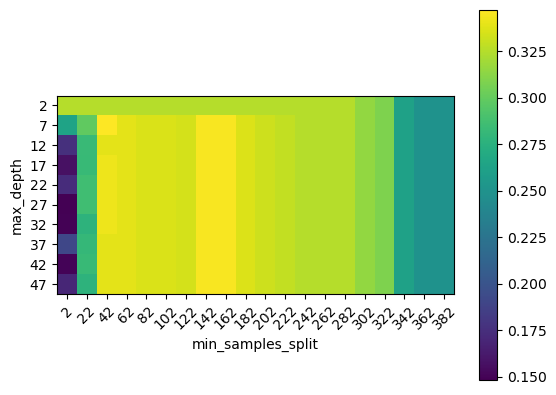

In [48]:
import matplotlib.pyplot as plt

par1 = grid.param_grid["max_depth"]
par2 = grid.param_grid["min_samples_split"]

r2 = grid.cv_results_["mean_test_score"].reshape(len(par1), len(par2))
plt.imshow(r2)
plt.yticks(np.arange(len(par1)), par1)
plt.xticks(np.arange(len(par2)), par2, rotation=45)
plt.ylabel("max_depth")
plt.xlabel("min_samples_split")
plt.colorbar()

B.DODATNO: poglej si in preizkusi še **RandomizedSearchCV**, **HalvingGridSearchCV** ter **HalvingRandomSearchCV**. Opisani so tukaj: https://scikit-learn.org/stable/modules/grid_search.html.